In [1]:
import json
from pathlib import Path

import librosa
import librosa.display
import librosa.feature
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from scipy import signal
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve

from tqdm import tqdm
from tsfresh import extract_features, select_features
from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters
from tsfresh.feature_extraction.settings import from_columns
from tsfresh.utilities.dataframe_functions import impute

ROOT_PATH = Path("..")

sns.set_style("white")

plt.rcParams["figure.figsize"] = [20, 10]
plt.rcParams["figure.dpi"] = 100

XGBoostError: XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed (vcomp140.dll or libgomp-1.dll for Windows, libomp.dylib for Mac OSX, libgomp.so for Linux and other UNIX-like OSes). Mac OSX users: Run `brew install libomp` to install OpenMP runtime.
  * You are running 32-bit Python on a 64-bit OS
Error message(s): ['dlopen(/Users/Malika/Documents/CMU/21S/DataScience/final/pracds_final/venv/lib/python3.8/site-packages/xgboost/lib/libxgboost.dylib, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib\n  Referenced from: /Users/Malika/Documents/CMU/21S/DataScience/final/pracds_final/venv/lib/python3.8/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: image not found']


# Get ids, labels, and train-test splits

In [ ]:
df = pd.read_csv(ROOT_PATH / "data/raw/metadata.csv")
# svc - song vs call ids
# filter ids -> <20s, quality A & B
# svc ids -> only rows that have call or song (not both)
filter_ids = pd.read_json(ROOT_PATH / "data/raw/filter_ids.json").squeeze()
svc_ids = pd.read_json(ROOT_PATH / "data/raw/song_vs_call.json").squeeze()
svc_df = df.loc[df.id.isin(svc_ids)].copy()
# set index to id
svc_df.set_index("id", inplace=True)

with open(ROOT_PATH / "data/processed/svc_split.json") as svc_split_file:
    svc_split = json.load(svc_split_file)
    train_ids = svc_split["train_ids"]
    test_ids = svc_split["test_ids"]

In [ ]:
# Add response variable
type_col = svc_df.type.str.lower().str.replace(" ", "").str.split(",")
filtered_type_col = type_col.apply(lambda l: set(l) - {"call", "song"})
svc_df["pred"] = type_col.apply(lambda l: "call" in l).astype(int)

In [ ]:
# Build y train-test
# indexing all (svc_df and y_df) by id
y_df = svc_df["pred"]
y_train, y_test = (
    y_df[y_df.index.isin(train_ids)].squeeze(),
    y_df[y_df.index.isin(test_ids)].squeeze(),
)

# Featurize Audio

## Convert Audio to Timeseries, Run High-pass Filter

In [ ]:
# apply butter filter
def highpass_filter(audio, sr):
    # butter_coeff_b, butter_coeff_a = signal.butter(3, 1000, btype='highpass', fs=sr) # numerator and denominator
    # butter_audio = signal.lfilter(butter_coeff_b, butter_coeff_a, audio)
    # return butter_audio
    return signal.lfilter(*signal.butter(3, 1000, btype="highpass", fs=sr), audio)

In [ ]:
# unpack an mp3 or wav into df of timeseries values
def unpack_audio(id):
    try:
        audio_path = ROOT_PATH / ("data/raw/recordings/" + str(id) + ".mp3")
        # load mp3 as audio timeseries arr
        timeseries, sr = librosa.load(audio_path)
    except FileNotFoundError:
        audio_path = ROOT_PATH / ("data/raw/recordings/" + str(id) + ".wav")
        timeseries, sr = librosa.load(audio_path)

    # high-pass filter on audio timeseries
    timeseries_filt = highpass_filter(timeseries, sr)

    df = pd.DataFrame(timeseries_filt, columns=["val"])
    df.reset_index(inplace=True)
    df["id"] = id  # fill col with id
    df = df.reindex(columns=["id", "index", "val"])
    df.columns = ["id", "time", "val"]
    return df

In [ ]:
# %%timeit
# unpack_audio(svc_ids[0])

## Extract Features

In [16]:
# select features to calculate
# features can be found here: https://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_extraction.html#tsfresh.feature_extraction.feature_calculators.fft_aggregated
manual_fc_params = {
    "abs_energy": None,
    "fft_aggregated": [{"aggtype": "centroid"}, {"aggtype": "kurtosis"}],
    "root_mean_square": None,
    "spkt_welch_density": [{"coeff": 2}, {"coeff": 5}, {"coeff": 8}],
}

selected_fc_params = {
    "standard_deviation": None,
    "variance": None,
    "root_mean_square": None,
}


def featurize_audio(id, fc_params):
    return extract_features(
        unpack_audio(id),
        column_id="id",
        column_sort="time",
        default_fc_parameters=fc_params,
        disable_progressbar=True,
        # we impute = remove all NaN features automatically
        impute_function=impute,
        # turn off parallelization
        n_jobs=0,
    )

In [17]:
# featurize dataset
# returns df of all combined
def featurize_set(ids, fc_params=None):
    if fc_params is None:
        fc_params = EfficientFCParameters()
    X_df = pd.DataFrame()
    for id in tqdm(ids):
        X_df = pd.concat([X_df, featurize_audio(id, fc_params)])
    return X_df

In [ ]:
# calculate features
# takes 1 hr
# X_df = featurize_set(svc_ids, manual_fc_params)

In [ ]:
# save calculated features
# X_df.to_json(ROOT_PATH / f"data/processed/audio_features_manual.json", indent=2, orient='columns')

In [18]:
# load features
X_df = pd.read_json(
    path_or_buf=ROOT_PATH / "data/processed/audio_features.json", orient="columns"
)

In [ ]:
X_df

In [ ]:
# plot features
full_df = X_df.copy()
full_df["label"] = y_df
full_df


def plot_audio_byfeat(ix, iy, x_title, y_title, x_lim=None, y_lim=None):
    plt.scatter(
        ix.loc[full_df["label"] == 1],
        iy.loc[full_df["label"] == 1],
        marker="x",
        color="C0",
    )
    plt.scatter(
        ix.loc[full_df["label"] == 0],
        iy.loc[full_df["label"] == 0],
        marker="+",
        color="C3",
    )
    if x_lim is not None:
        plt.xlim([0, x_lim])
    if y_lim is not None:
        plt.ylim([0, y_lim])
    plt.xlabel(x_title)
    plt.ylabel(y_title)
    plt.legend(["call", "song"])


spectral_density = full_df["val__spkt_welch_density__coeff_8"]
fft_centroid = full_df['val__fft_aggregated__aggtype_"centroid"']
fft_kurtosis = full_df['val__fft_aggregated__aggtype_"kurtosis"']
rms = full_df["val__root_mean_square"]
abs_energy = full_df["val__abs_energy"]


plt.subplot(2, 3, 1)
plot_audio_byfeat(
    spectral_density, fft_centroid, "spectral density", "fft centroid", 0.01, 150000
)
plt.subplot(2, 3, 2)
plot_audio_byfeat(spectral_density, rms, "spectral density", "rms", 0.01, 0.15)
plt.subplot(2, 3, 3)
plot_audio_byfeat(
    spectral_density, abs_energy, "spectral density", "abs energy", 0.01, 4000
)
plt.subplot(2, 3, 4)
plot_audio_byfeat(fft_centroid, rms, "fft centroid", "rms", 150000, 0.15)
plt.subplot(2, 3, 5)
plot_audio_byfeat(fft_centroid, abs_energy, "fft centroid", "abs energy", 150000, 4000)

In [19]:
# get train-test split of features

X_train, X_test = (
    X_df[X_df.index.isin(train_ids)].squeeze(),
    X_df[X_df.index.isin(test_ids)].squeeze(),
)

In [38]:
# logistic regression

lr = LogisticRegression()
lr.fit(X_train, y_train)
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.5680459770114943
0.5910344827586207


In [39]:
# logistic regression with normalizing
from sklearn.preprocessing import StandardScaler

norm = StandardScaler()

lr_norm = LogisticRegression()
lr_norm.fit(norm.fit_transform(X_train), y_train)
print(lr_norm.score(norm.transform(X_train), y_train))
print(lr_norm.score(norm.transform(X_test), y_test))

0.587816091954023
0.6103448275862069


In [ ]:
# looks like the model always predicts call :(
np.where(not np.isclose(lr_norm.predict_proba(X_test), [1.0, 0.0]).all())

In [40]:
# compare loss and error with baseline
from sklearn.metrics import log_loss

train_pred = lr_norm.predict_proba(X_train)[:, 0]
train_loss = log_loss(y_train, train_pred)

test_pred = lr_norm.predict_proba(X_test)[:, 0]
test_loss = log_loss(y_test, test_pred)
# logreg_error = (lr_norm.predict(norm.transform(X_test)) != y_test).mean()  # mean error = 1-accuracy

# baseline_pred = np.repeat(1, y_test.size) # always guess 1
baseline_pred = np.repeat(y_train.mean(), y_test.size)  # guess the mean
baseline_loss = log_loss(y_test, baseline_pred)
baseline_error = (1 != y_test).mean()

print(train_loss, test_loss)
# print(baseline_loss, baseline_error)

15.530898997935346 15.792923367532413


In [27]:
print(y_train.mean())
print(y_test.mean())

0.5503448275862068
0.5427586206896552


In [54]:
# rows are training set sizes [0.1, 0.33, 0.55, 0.78, 1.0]
# cols are cross-validation splits
train_sizes, train_scores, validation_scores = learning_curve(
    estimator = LogisticRegression(),
    X = X_df,
    y = y_df, 
    cv = 5, shuffle=True, scoring='neg_log_loss')

train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)

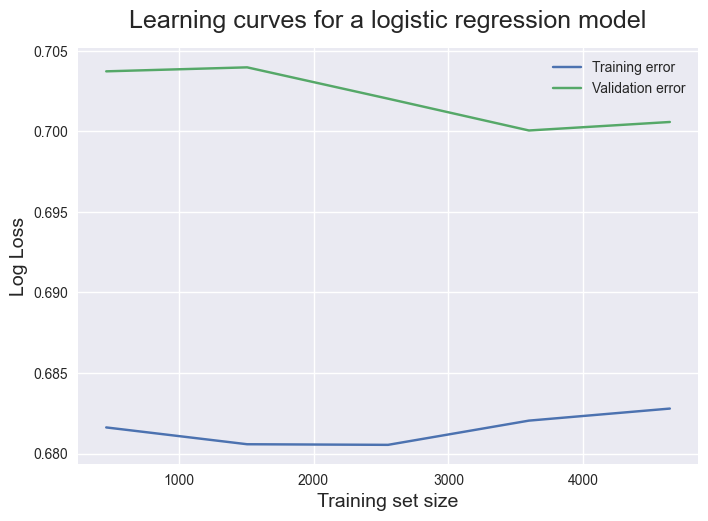

In [59]:
f, ax = plt.subplots()
plt.style.use('seaborn')
ax.plot(train_sizes, train_scores_mean, label = 'Training error')
ax.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('Log Loss', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a logistic regression model', fontsize = 18, y = 1.03)
plt.legend()
f.savefig(f"assets/logreg_learning", dpi=150);

In [ ]:
xgb_clf = xgb.XGBClassifier()
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_clf.fit(
    X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False
)

print(xgb_clf.score(X_test, y_test))

In [ ]:
# Loss
# retrieve performance metrics
results = xgb_clf.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0, epochs)

# plot log loss
f, ax = plt.subplots()
ax.plot(x_axis, results["validation_0"]["logloss"], label="Train")
ax.plot(x_axis, results["validation_1"]["logloss"], label="Test")
ax.legend()
sns.despine(f, ax)
plt.ylabel("Log Loss")
plt.xlabel("Epochs")
plt.title("Log Loss vs Epochs (XGBoost Audio Timeseries Model)")

f.tight_layout()
fig_name = "svc_audiotime_xgb_loss.png"
f.savefig(f"assets/{fig_name}", dpi=150);

In [ ]:
xgb_train_acc = xgb_clf.score(X_train, y_train)
xgb_test_acc = xgb_clf.score(X_test, y_test)

print(f"Train Loss: {results['validation_0']['logloss'][-1]:.3f}")
print(f"Test Loss:  {results['validation_1']['logloss'][-1]:.3f}")

print(f"Train Accuracy: {xgb_train_acc:.3f}")
print(f"Test Accuracy:  {xgb_test_acc:.3f}")

# Full workflow using random smaller subset of data

In [ ]:
def get_rand_split_ids(percent, train_ids, test_ids):
    # random subset of train
    train_rand_ids = np.random.choice(
        train_ids, size=int(len(train_ids) * percent), replace=False
    )
    # random subset of test
    test_rand_ids = np.random.choice(
        test_ids, size=int(len(test_ids) * percent), replace=False
    )
    return train_rand_ids, test_rand_ids

In [ ]:
# test and compare multiple featurization (feature calculator) options
# useful to run on a subset of the data


def test_multiple_featurizations(train_rand_ids, test_rand_ids, *featurization_lst):
    all_rand_ids = np.concatenate((train_rand_ids, test_rand_ids))

    # lists across feature calcs:
    X_rand_lst = []  # df of features
    X_train_rand_lst = []  # df of features for train
    X_test_rand_lst = []  # df of features for test
    models_lst = []  # lr models
    scores_lst = []

    # make train-test splits of labels
    y_train_rand, y_test_rand = (
        y_df[y_df.index.isin(train_rand_ids)].drop(columns=["id"]).squeeze(),
        y_df[y_df.index.isin(test_rand_ids)].drop(columns=["id"]).squeeze(),
    )

    # run through full workflow for each feature calculator
    for featurization in featurization_lst:
        # featurize data from given ids
        X_rand = featurize_set(all_rand_ids, featurization)
        X_rand_lst.append(X_rand)

        # make train-test splits of featurized data
        X_train_rand, X_test_rand = (
            X_rand[X_rand.index.isin(train_rand_ids)].squeeze(),
            X_rand[X_rand.index.isin(test_rand_ids)].squeeze(),
        )
        # Why doesn't X_rand.loc[train_rand_ids,:] work? (wrong # rows)
        X_train_rand_lst.append(X_test_rand)
        X_test_rand_lst.append(X_train_rand)

        # train models
        lr = LogisticRegression()
        lr.fit(X_train_rand, y_train_rand)
        models_lst.append(lr)

        # score models
        score = lr.score(X_test_rand, y_test_rand)
        scores_lst.append(score)

    return X_rand_lst, models_lst, scores_lst

In [ ]:
# generate random ids from 5% of dataset
train_rand_ids, test_rand_ids = get_rand_split_ids(0.05, train_ids, test_ids)

# make train-test splits of labels
y_train_rand, y_test_rand = (
    y_df[y_df.index.isin(train_rand_ids)].drop(columns=["id"]).squeeze(),
    y_df[y_df.index.isin(test_rand_ids)].drop(columns=["id"]).squeeze(),
)

# check that we have a good distribution of value counts
print(y_train_rand.value_counts())
print(y_test_rand.value_counts())

In [ ]:
print(len(train_rand_ids))
print(len(y_train_rand))

In [ ]:
# Features to extract (options)

# presets can be found here: https://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_extraction.html#tsfresh.feature_extraction.settings.ComprehensiveFCParameters
# with more details here: https://tsfresh.readthedocs.io/en/latest/_modules/tsfresh/feature_extraction/settings.html#MinimalFCParameters
# manual_fc_params
# selected_fc_params
# EfficientFCParameters()
# ComprehensiveFCParameters()
# MinimalFCParameters()


manual_fc_params_A = {
    "abs_energy": None,
    "fft_aggregated": [{"aggtype": "centroid"}, {"aggtype": "kurtosis"}],
    "root_mean_square": None,
    "spkt_welch_density": [{"coeff": 2}, {"coeff": 5}, {"coeff": 8}],
}

# manual_fc_params_B = {
#                         "abs_energy": None,
#                         "fft_aggregated": [{"aggtype":"centroid"}],
#                         "root_mean_square": None,
#                         "spkt_welch_density": [{"coeff":2},{"coeff":5},{"coeff":8}]
# }
# manual_fc_params_C = {
#                         "abs_energy": None,
#                         "fft_aggregated": [{"aggtype":"centroid"}, {"aggtype":"kurtosis"}],
#                         "root_mean_square": None,
#                         "spkt_welch_density": [{"coeff":2},{"coeff":5},{"coeff":8}],
#                         "number_crossing_m": [{"m":0}]
# }


# manual_fc_params_B = {
#                         "abs_energy": None,
#                         "fft_aggregated": [{"aggtype":"centroid"}, {"aggtype":"kurtosis"}, {"aggtype":"skew"}, {"aggtype":"variance"}],
#                         "root_mean_square": None,
#                         "spkt_welch_density": [{"coeff":2},{"coeff":5},{"coeff":8}]
# }

In [ ]:
# takes 3 mins for manual, 5% of dataset
# takes 168.2 s for minimal, 5% of dataset
# takes 169s for selected (3 features), 5% of dataset
# takes 542s (9m) for all 3, 5% of dataset
# takes 13h for efficient fc, 0.5% of dataset

X_rand_lst, models_lst, scores_lst = test_multiple_featurizations(
    train_rand_ids,
    test_rand_ids,
    MinimalFCParameters(),
    selected_fc_params,
    manual_fc_params,
)
# X_rand_lst, models_lst, scores_lst = test_multiple_featurizations(train_rand_ids, test_rand_ids, manual_fc_params_A, manual_fc_params_B, manual_fc_params_C)
# X_rand_lst, models_lst, scores_lst = test_multiple_featurizations(train_rand_ids, test_rand_ids, manual_fc_params_B)
# X_rand_lst, models_lst, scores_lst = test_multiple_featurizations(train_rand_ids, test_rand_ids, EfficientFCParameters())

In [ ]:
for score in scores_lst:
    print(score)

In [ ]:
compare_preset_sel_manual = {
    "X": X_rand_lst.copy(),
    "models": models_lst.copy(),
    "scores": scores_lst.copy(),
}
# compare_manual = {'X': X_rand_ls.copy(), 'models': models_lst.copy(), 'scores': scores_lst.copy()}

In [ ]:
# select good features from the first feature calculator list
# make train-test splits of featurized data
X_for_selection = X_rand_lst[0]
X_train_for_selection, X_test_for_selection = (
    X_for_selection[X_for_selection.index.isin(train_rand_ids)].squeeze(),
    X_for_selection[X_for_selection.index.isin(test_rand_ids)].squeeze(),
)

X_selected = select_features(X_train_for_selection, y_train_rand)

# get a dictionary of the good features parameters, to use again later
kind_to_fc_parameters = from_columns(X_selected)
# new_selected_fc_params = kind_to_fc_parameters['val']

In [ ]:
for score in compare_preset_sel_manual["scores"]:
    print(score)
# for score in compare_manual['scores']:
#     print(score)